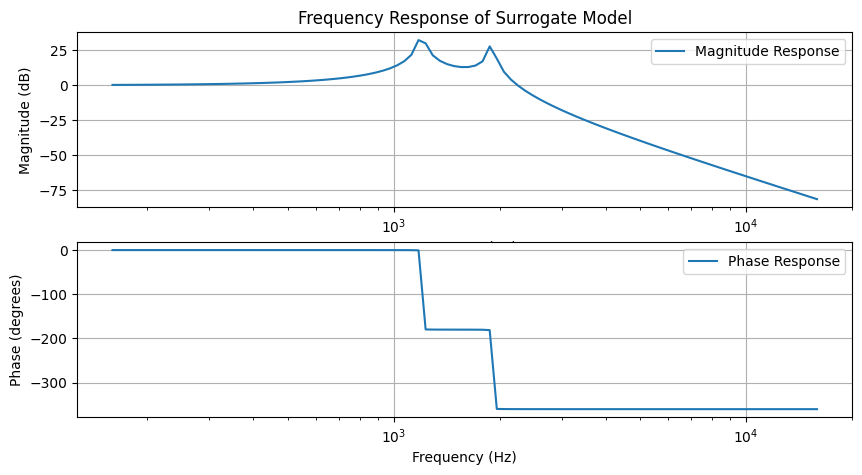

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

class SurrogateCrankshaftModel:
    def __init__(self, freqs, dampings):
        """Initialize surrogate model with dominant natural frequencies and damping ratios."""
        self.freqs = np.array(freqs)  # Natural frequencies in Hz
        self.omegas = 2 * np.pi * self.freqs  # Convert to rad/s
        self.dampings = np.array(dampings)  # Damping ratios
        self.system = self.create_transfer_function()
    
    def create_transfer_function(self):
        """Create a surrogate transfer function model for the crankshaft with multiple modes."""
        num = np.zeros(3)
        den = np.array([1.0])
        
        for omega_n, zeta in zip(self.omegas, self.dampings):
            mode_num = np.array([omega_n**2])
            mode_den = np.array([1, 2*zeta*omega_n, omega_n**2])
            
            if len(den) == 1:
                num, den = mode_num, mode_den
            else:
                num = np.convolve(num, mode_num)
                den = np.convolve(den, mode_den)
        
        return signal.TransferFunction(num, den)
    
    def plot_frequency_response(self):
        """Plot the frequency response of the surrogate model."""
        w, mag, phase = signal.bode(self.system)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(2, 1, 1)
        plt.semilogx(w / (2 * np.pi), mag, label='Magnitude Response')
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude (dB)")
        plt.title("Frequency Response of Surrogate Model")
        plt.legend()
        plt.grid()
        
        plt.subplot(2, 1, 2)
        plt.semilogx(w / (2 * np.pi), phase, label='Phase Response')
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Phase (degrees)")
        plt.legend()
        plt.grid()
        
        plt.show()

# Example Usage
natural_freqs = [1200, 1900]  # Dominant natural frequencies in Hz
damping_ratios = [0.0002, 0.0003]  # Estimated damping for each mode

surrogate = SurrogateCrankshaftModel(natural_freqs, damping_ratios)
surrogate.plot_frequency_response()

Undamped natural frequencies [rad/s]: [ 5.67979386 12.7569566 ]
Max |E_physical - E_modes| across the sweep: 8.88e-16


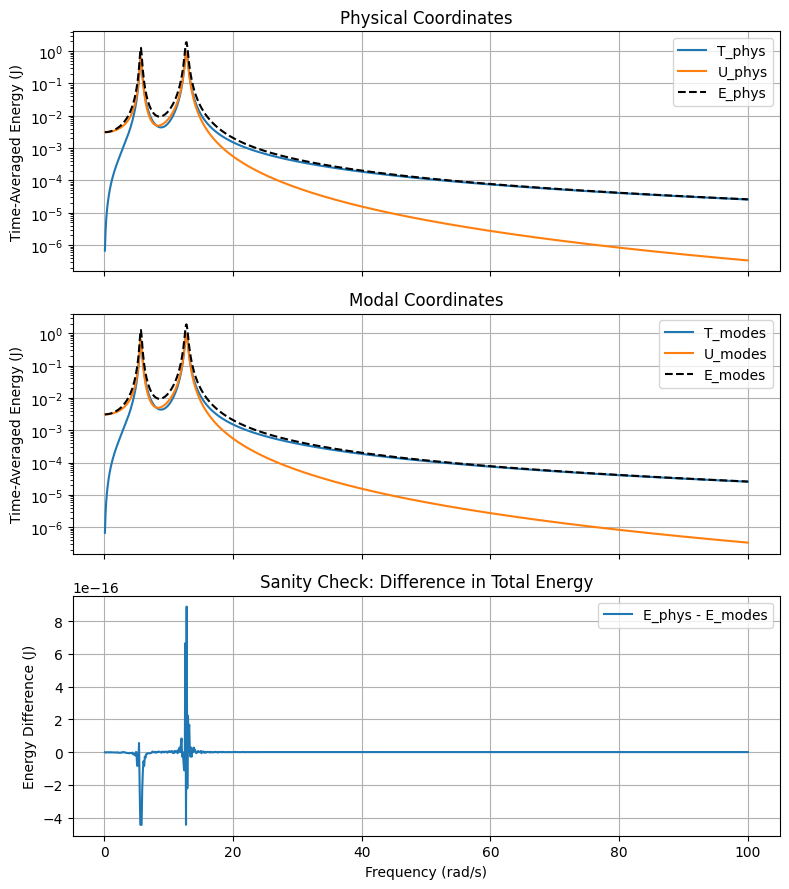

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Define system matrices
# ---------------------------------------------------------
m1, m2 = 1.0, 2.0
k1, k2, k3 = 50.0, 80.0, 50.0

# Mass matrix
M = np.array([[m1,   0.0],
              [0.0,  m2 ]])

# Stiffness matrix
K = np.array([[k1 + k2,   -k2   ],
              [   -k2  , k2 + k3]])

# Small damping to avoid infinite resonance
c1, c2 = 0.5, 0.5
C = np.array([[c1,  0.0],
              [0.0, c2 ]])

# ---------------------------------------------------------
# 2. For reference: undamped modal properties
# ---------------------------------------------------------
lam, Phi = np.linalg.eig(np.linalg.inv(M).dot(K))
omega_n = np.sqrt(lam)

# Sort ascending
idx = np.argsort(omega_n)
omega_n = omega_n[idx]
Phi = Phi[:, idx]

# Mass-normalize the modes: Phi^T M Phi = I
for i in range(Phi.shape[1]):
    mass_modal = Phi[:, i].T @ M @ Phi[:, i]
    Phi[:, i] = Phi[:, i] / np.sqrt(mass_modal)

print("Undamped natural frequencies [rad/s]:", omega_n)

# ---------------------------------------------------------
# 3. Define harmonic forcing (applied on DOF 1)
# ---------------------------------------------------------
F0 = np.array([1.0, 0.0])   # amplitude vector (complex)
omega_min, omega_max = 0.1, 100.0
omegas = np.linspace(omega_min, omega_max, 1000)

# ---------------------------------------------------------
# 4. Frequency sweep
# ---------------------------------------------------------
T_list_physical = []
U_list_physical = []
E_list_physical = []

T_list_modes = []
U_list_modes = []
E_list_modes = []

for w in omegas:
    # Dynamic stiffness: D(w) = (-w^2 M + j w C + K)
    D = -w**2 * M + 1j*w * C + K
    
    # Solve for steady-state X(w) in physical coords
    X = np.linalg.solve(D, F0)  # shape: (2, )
    
    # 4a) Time-averaged energies in PHYSICAL coordinates
    # Kinetic: T_avg = (1/4)* X^*(w)^T (w^2 M) X(w)
    T_physical = 0.25 * (X.conjugate().T @ (w**2 * M) @ X).real
    
    # Potential: U_avg = (1/4)* X^*(w)^T K X(w)
    U_physical = 0.25 * (X.conjugate().T @ K @ X).real
    
    E_physical = T_physical + U_physical
    
    T_list_physical.append(T_physical)
    U_list_physical.append(U_physical)
    E_list_physical.append(E_physical)
    
    # 4b) Transform to modal coords: Q(w) = Phi^T M X(w)
    #     (Phi is mass-normalized => Potential ~ omega_r^2 |Q_r|^2, Kinetic ~ w^2 |Q_r|^2)
    Q = Phi.T @ M @ X  # shape: (2, )
    
    # For each mode r:
    #   T_r_avg = 1/4 * w^2 * |Q_r|^2
    #   U_r_avg = 1/4 * omega_r^2 * |Q_r|^2
    # Summation across r gives total energy in modes
    T_modes = 0.0
    U_modes = 0.0
    for r in range(2):
        qr = Q[r]
        T_modes += 0.25 * w**2 * np.abs(qr)**2
        U_modes += 0.25 * omega_n[r]**2 * np.abs(qr)**2
    
    E_modes = T_modes + U_modes
    
    T_list_modes.append(T_modes)
    U_list_modes.append(U_modes)
    E_list_modes.append(E_modes)


T_list_physical = np.array(T_list_physical)
U_list_physical = np.array(U_list_physical)
E_list_physical = np.array(E_list_physical)

T_list_modes = np.array(T_list_modes)
U_list_modes = np.array(U_list_modes)
E_list_modes = np.array(E_list_modes)

# ---------------------------------------------------------
# 5. Check the difference: E_physical vs E_modes
# ---------------------------------------------------------
E_diff = E_list_physical - E_list_modes  # ideally ~ 0
max_diff = np.max(np.abs(E_diff))
print(f"Max |E_physical - E_modes| across the sweep: {max_diff:.2e}")

# ---------------------------------------------------------
# 6. Plot
# ---------------------------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(8,9), sharex=True)

axs[0].plot(omegas, T_list_physical, label="T_phys")
axs[0].plot(omegas, U_list_physical, label="U_phys")
axs[0].plot(omegas, E_list_physical, 'k--', label="E_phys")
axs[0].set_ylabel("Time-Averaged Energy (J)")
axs[0].set_title("Physical Coordinates")
axs[0].legend()
axs[0].grid(True)
axs[0].set_yscale('log')

axs[1].plot(omegas, T_list_modes, label="T_modes")
axs[1].plot(omegas, U_list_modes, label="U_modes")
axs[1].plot(omegas, E_list_modes, 'k--', label="E_modes")
axs[1].set_ylabel("Time-Averaged Energy (J)")
axs[1].set_title("Modal Coordinates")
axs[1].legend()
axs[1].grid(True)
axs[1].set_yscale('log')

axs[2].plot(omegas, E_diff, label="E_phys - E_modes")
axs[2].set_xlabel("Frequency (rad/s)")
axs[2].set_ylabel("Energy Difference (J)")
axs[2].set_title("Sanity Check: Difference in Total Energy")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

At frequency w=3.00, displacement phasors X = [-0.04642122-0.0042076j  -0.11598852-0.00356226j]
Sum of forces = [0.83558197+0.07573672j 2.08779333+0.06412066j] (should be ~0)


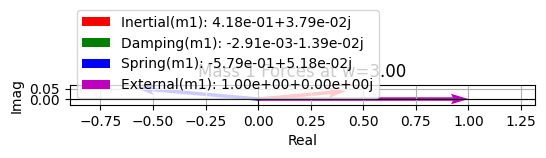

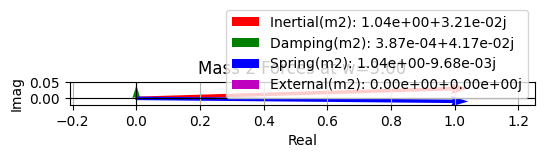

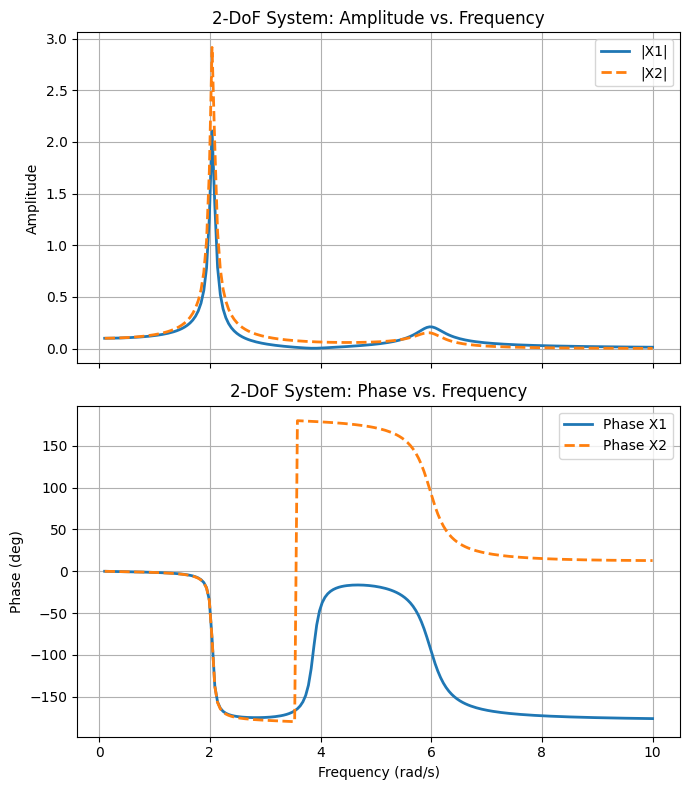

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def solve_2dof_phasors(M, C, K, F0, omega):
    """
    Solve the steady-state response for a 2-DoF system with forcing
    F(t) = Re{ F0 * exp(i omega t) } at a single frequency omega.

    :param M, C, K: 2x2 numpy arrays (mass, damping, stiffness matrices).
    :param F0: 2-element complex forcing vector (phasor).
    :param omega: scalar frequency.
    :return: X (2-element complex displacement phasor).
    """
    # Dynamic stiffness matrix:
    A = -omega**2 * M + 1j*omega*C + K
    # Solve A * X = F0
    X = np.linalg.solve(A, F0)
    return X

def compute_forces_2dof(M, C, K, X, omega, F0):
    """
    Compute the phasors of inertial, damping, spring, and external forces
    for each mass (2-element vectors).

    :param M, C, K: 2x2 numpy arrays
    :param X: 2-element displacement phasor
    :param omega: driving frequency
    :param F0: 2-element forcing phasor
    :return: (F_inertial, F_damping, F_spring, F_external),
             each a 2-element complex vector
    """
    # Inertial force = -M * (omega^2) * X
    F_inertial = - M * (omega**2) @ X
    # Damping force = -i omega C X
    F_damping  = -1j * omega * C @ X
    # Spring force = -K X
    F_spring   = - K @ X
    # External force (phasor) = F0
    F_external = F0
    return F_inertial, F_damping, F_spring, F_external

def plot_forces_in_complex_plane(forces, labels, title="Forces in Complex Plane"):
    """
    Plot multiple complex vectors (forces) as arrows from origin in an Argand diagram.

    :param forces: list of complex numbers
    :param labels: list of string labels
    """
    fig, ax = plt.subplots(figsize=(6,6))

    colors = ['r','g','b','m','c','y','k']
    for i, (F, lbl) in enumerate(zip(forces, labels)):
        x, y = F.real, F.imag
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy',
                  scale=1, color=colors[i % len(colors)],
                  label=f"{lbl}: {F:.2e}")

    # Auto-limits with margin
    reals = [f.real for f in forces]
    imags = [f.imag for f in forces]
    x_min, x_max = min(reals), max(reals)
    y_min, y_max = min(imags), max(imags)
    dx = x_max - x_min if (x_max - x_min) != 0 else 1
    dy = y_max - y_min if (y_max - y_min) != 0 else 1
    margin = 0.2
    ax.set_xlim([x_min - margin*dx, x_max + margin*dx])
    ax.set_ylim([y_min - margin*dy, y_max + margin*dy])

    ax.axhline(0, color='black', linewidth=0.8)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('Real')
    ax.set_ylabel('Imag')
    ax.set_title(title)
    ax.legend(loc='best')
    ax.grid(True)
    plt.show()

def bode_2dof(M, C, K, F0, w_array):
    """
    Sweep over frequencies in w_array, solve for X(omega),
    and then plot amplitude & phase for each DOF (x1, x2).
    """
    amp_1 = np.zeros_like(w_array, dtype=float)
    amp_2 = np.zeros_like(w_array, dtype=float)
    phase_1 = np.zeros_like(w_array, dtype=float)
    phase_2 = np.zeros_like(w_array, dtype=float)
    
    for i, w in enumerate(w_array):
        X = solve_2dof_phasors(M, C, K, F0, w)
        x1, x2 = X[0], X[1]
        amp_1[i]   = np.abs(x1)
        amp_2[i]   = np.abs(x2)
        phase_1[i] = np.angle(x1)  # radians
        phase_2[i] = np.angle(x2)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,8), sharex=True)

    # --- Amplitude plots ---
    ax1.plot(w_array, amp_1, label="|X1|", lw=2)
    ax1.plot(w_array, amp_2, label="|X2|", lw=2, ls='--')
    ax1.set_ylabel("Amplitude")
    ax1.set_title("2-DoF System: Amplitude vs. Frequency")
    ax1.grid(True)
    ax1.legend()

    # --- Phase plots (in degrees) ---
    ax2.plot(w_array, np.degrees(phase_1), label="Phase X1", lw=2)
    ax2.plot(w_array, np.degrees(phase_2), label="Phase X2", lw=2, ls='--')
    ax2.set_xlabel("Frequency (rad/s)")
    ax2.set_ylabel("Phase (deg)")
    ax2.set_title("2-DoF System: Phase vs. Frequency")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

def main():
    # ---------------------------------------------------------
    # Example system parameters (2-DoF)
    # ---------------------------------------------------------
    m1, m2 = 1.0, 1.0
    c1, c2 = 0.2, 0.2
    k1, k2 = 10.0, 15.0

    M = np.array([[m1,   0 ],
                  [ 0,  m2 ]])
    C = np.array([[c1+c2, -c2 ],
                  [-c2,    c2 ]])
    K = np.array([[k1+k2, -k2 ],
                  [-k2,    k2 ]])

    # Suppose we force only mass 1 with amplitude F0_mag
    F0_mag = 1.0
    phi = 0.0  # phase offset
    F0 = np.array([ F0_mag*np.exp(1j*phi),  0.0 ])  # 2-element forcing

    # ---------------------------------------------------------
    # 1) Choose a single frequency, solve, and plot forces
    # ---------------------------------------------------------
    omega_single = 3.0  # pick a single frequency (rad/s)

    # Solve for displacement phasors
    X = solve_2dof_phasors(M, C, K, F0, omega_single)
    print(f"At frequency w={omega_single:.2f}, displacement phasors X = {X}")

    # Compute the 2-element force vectors
    F_inertial, F_damping, F_spring, F_external = compute_forces_2dof(M, C, K, X, omega_single, F0)
    sum_forces = F_inertial + F_damping + F_spring + F_external
    print(f"Sum of forces = {sum_forces} (should be ~0)")

    # --- Argand plot for each mass separately ---
    # mass 1 experiences F_inertial[0], F_damping[0], F_spring[0], F_external[0]
    forces_m1 = [F_inertial[0], F_damping[0], F_spring[0], F_external[0]]
    labels_m1 = ["Inertial(m1)", "Damping(m1)", "Spring(m1)", "External(m1)"]
    plot_forces_in_complex_plane(forces_m1, labels_m1,
        title=f"Mass 1 Forces at w={omega_single:.2f}")

    # mass 2 experiences F_inertial[1], F_damping[1], F_spring[1], F_external[1]
    forces_m2 = [F_inertial[1], F_damping[1], F_spring[1], F_external[1]]
    labels_m2 = ["Inertial(m2)", "Damping(m2)", "Spring(m2)", "External(m2)"]
    plot_forces_in_complex_plane(forces_m2, labels_m2,
        title=f"Mass 2 Forces at w={omega_single:.2f}")

    # ---------------------------------------------------------
    # 2) Sweep frequencies for a Bode-like plot
    # ---------------------------------------------------------
    w_array = np.linspace(0.1, 10, 200)
    bode_2dof(M, C, K, F0, w_array)

if __name__ == "__main__":
    main()

Natural Frequencies (rad/s): [3.35710687 9.41965145]
Mass-Normalized Mode Shapes:
[[-0.33571069 -0.94196515]
 [-0.62797676  0.22380712]]


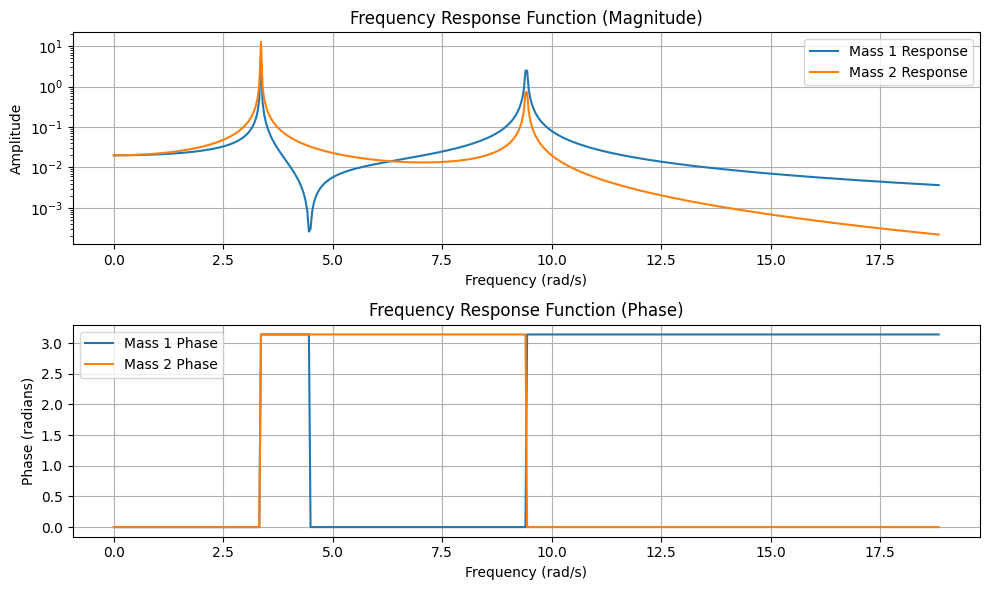

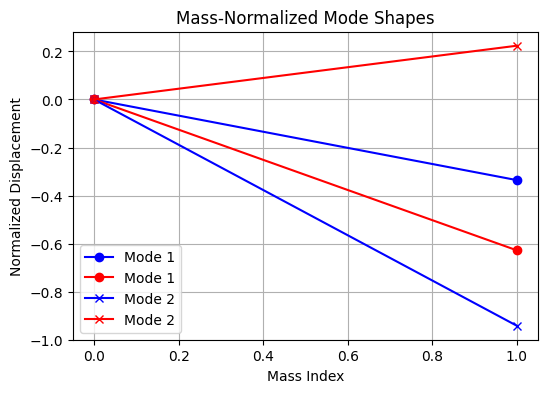

In [9]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import eigh, inv
import matplotlib.pyplot as plt

def mdof_system(t, y, m1, m2, k1, k2):
    x1, v1, x2, v2 = y
    
    # Equations of motion
    a1 = (-k1 * x1 - k2 * (x1 - x2)) / m1
    a2 = (k2 * (x1 - x2)) / m2
    
    return [v1, a1, v2, a2]

# System parameters
m1 = 1.0   # kg
m2 = 1.5   # kg
k1 = 50.0  # N/m
k2 = 30.0  # N/m

t_span = (0, 10)  # Time range (seconds)
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points for evaluation

# Initial conditions: [x1, v1, x2, v2]
y0 = [0.1, 0.0, 0.0, 0.0]  # Small displacement for mass 1

# Solve the system
sol = solve_ivp(mdof_system, t_span, y0, args=(m1, m2, k1, k2), t_eval=t_eval)

# Extract solutions
t = sol.t
x1, v1, x2, v2 = sol.y

# Compute spring forces
F_k1 = k1 * x1
F_k2 = k2 * (x2 - x1)

# Compute energies
KE1 = 0.5 * m1 * v1**2
KE2 = 0.5 * m2 * v2**2
KE_total = KE1 + KE2

PE1 = 0.5 * k1 * x1**2
PE2 = 0.5 * k2 * (x2 - x1)**2
PE_total = PE1 + PE2

E_total = KE_total + PE_total

# Modal Analysis
M = np.array([[m1, 0], [0, m2]])
K = np.array([[k1 + k2, -k2], [-k2, k2]])

# Compute eigenvalues and eigenvectors
w2, V = eigh(K, M)  # Solve the generalized eigenvalue problem
natural_frequencies = np.sqrt(w2)  # Convert eigenvalues to natural frequencies

# Mass-normalized mode shapes
M_sqrt_inv = np.linalg.inv(np.sqrt(M))
V_mass_norm = M_sqrt_inv @ V  # Normalize mode shapes with respect to mass

print("Natural Frequencies (rad/s):", natural_frequencies)
print("Mass-Normalized Mode Shapes:")
print(V_mass_norm)

# Frequency-Domain Analysis using Complex Numbers
omega = np.linspace(0, 2 * max(natural_frequencies), 500)  # Frequency range
FRF_complex = np.zeros((2, len(omega)), dtype=complex)

for i, w in enumerate(omega):
    D = -w**2 * M + K  # Dynamic stiffness matrix
    FRF_complex[:, i] = np.linalg.solve(D, np.array([1, 0]))  # Response to unit force on mass 1

# Plot Frequency Response (Magnitude and Phase)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.semilogy(omega, np.abs(FRF_complex[0, :]), label='Mass 1 Response')
plt.semilogy(omega, np.abs(FRF_complex[1, :]), label='Mass 2 Response')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Frequency Response Function (Magnitude)')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(omega, np.angle(FRF_complex[0, :]), label='Mass 1 Phase')
plt.plot(omega, np.angle(FRF_complex[1, :]), label='Mass 2 Phase')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Phase (radians)')
plt.legend()
plt.title('Frequency Response Function (Phase)')
plt.grid()

plt.tight_layout()
plt.show()

# Mode shape visualization
plt.figure(figsize=(6, 4))
plt.plot([0, 1], [0, V_mass_norm[0, 0]], 'bo-', label='Mode 1')
plt.plot([0, 1], [0, V_mass_norm[1, 0]], 'ro-', label='Mode 1')
plt.plot([0, 1], [0, V_mass_norm[0, 1]], 'bx-', label='Mode 2')
plt.plot([0, 1], [0, V_mass_norm[1, 1]], 'rx-', label='Mode 2')
plt.xlabel('Mass Index')
plt.ylabel('Normalized Displacement')
plt.legend()
plt.title('Mass-Normalized Mode Shapes')
plt.grid()
plt.show()


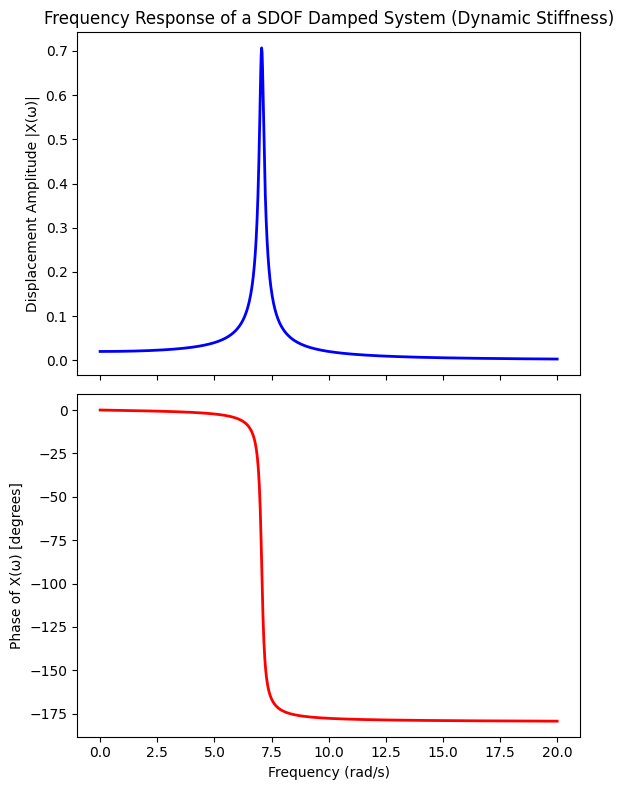

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def dynamic_stiffness(m, c, k, w):
    """
    Computes the dynamic stiffness for a single-DOF system:
    Z(w) = k - w^2 * m + j * w * c
    """
    return k - (w**2)*m + 1j*w*c

# System parameters
m = 1.0      # mass [kg]
c = 0.2      # damping coefficient [N s/m]
k = 50.0     # stiffness [N/m]
F0 = 1.0     # amplitude of the harmonic force

# Frequency range
w_min = 0.0
w_max = 20.0
num_points = 1000
w_vals = np.linspace(w_min, w_max, num_points)

# Pre-allocate response arrays
X_mag = np.zeros_like(w_vals)
X_phase = np.zeros_like(w_vals)

for i, w in enumerate(w_vals):
    Z = dynamic_stiffness(m, c, k, w)
    X = F0 / Z  # displacement amplitude (complex)
    
    X_mag[i] = np.abs(X)
    X_phase[i] = np.angle(X)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8), sharex=True)

# Magnitude plot
ax1.plot(w_vals, X_mag, 'b', lw=2)
ax1.set_ylabel('Displacement Amplitude |X(ω)|')
ax1.set_title('Frequency Response of a SDOF Damped System (Dynamic Stiffness)')

# Phase plot
ax2.plot(w_vals, np.degrees(X_phase), 'r', lw=2)
ax2.set_xlabel('Frequency (rad/s)')
ax2.set_ylabel('Phase of X(ω) [degrees]')

plt.tight_layout()
plt.show()

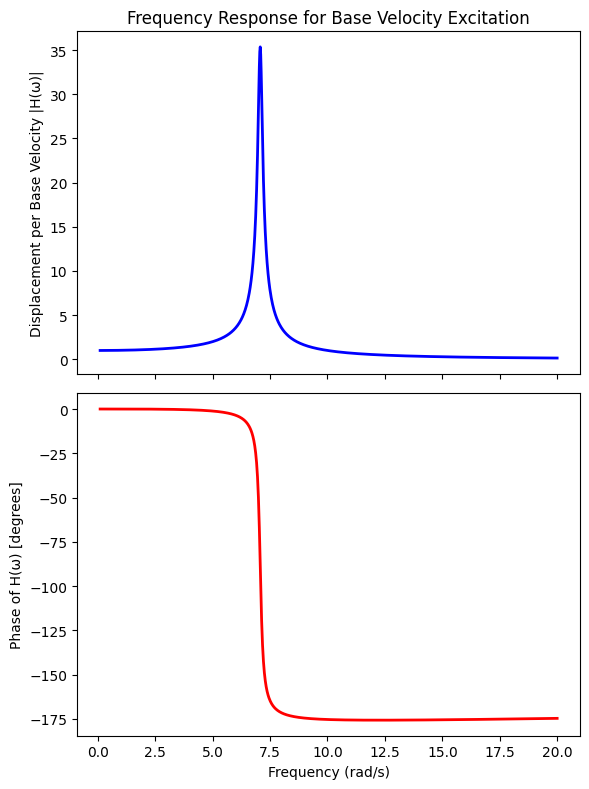

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def dynamic_stiffness(m, c, k, w):
    """
    Computes the dynamic stiffness for a single-DOF system:
    K_d(w) = k - w^2 * m + j * w * c
    """
    return k - (w**2)*m + 1j*w*c

def transfer_function_base_excitation(m, c, k, w):
    """
    Computes the frequency response function (H(ω)) for base velocity excitation:
    H(w) = jω (c + k / (jω)) / K_d(w)
    """
    K_d = dynamic_stiffness(m, c, k, w)
    numerator = 1j * w * (c + k / (1j * w))  # jω (c + k/jω)
    return numerator / K_d

# System parameters
m = 1.0      # Mass [kg]
c = 0.2      # Damping coefficient [N s/m]
k = 50.0     # Stiffness [N/m]

# Frequency range
w_min = 0.1   # Avoid division by zero
w_max = 20.0
num_points = 1000
w_vals = np.linspace(w_min, w_max, num_points)

# Compute frequency response function
H_vals = np.array([transfer_function_base_excitation(m, c, k, w) for w in w_vals])

# Extract magnitude and phase
H_mag = np.abs(H_vals)
H_phase = np.angle(H_vals)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# Magnitude plot
ax1.plot(w_vals, H_mag, 'b', lw=2)
ax1.set_ylabel('Displacement per Base Velocity |H(ω)|')
ax1.set_title('Frequency Response for Base Velocity Excitation')

# Phase plot
ax2.plot(w_vals, np.degrees(H_phase), 'r', lw=2)
ax2.set_xlabel('Frequency (rad/s)')
ax2.set_ylabel('Phase of H(ω) [degrees]')

plt.tight_layout()
plt.show()

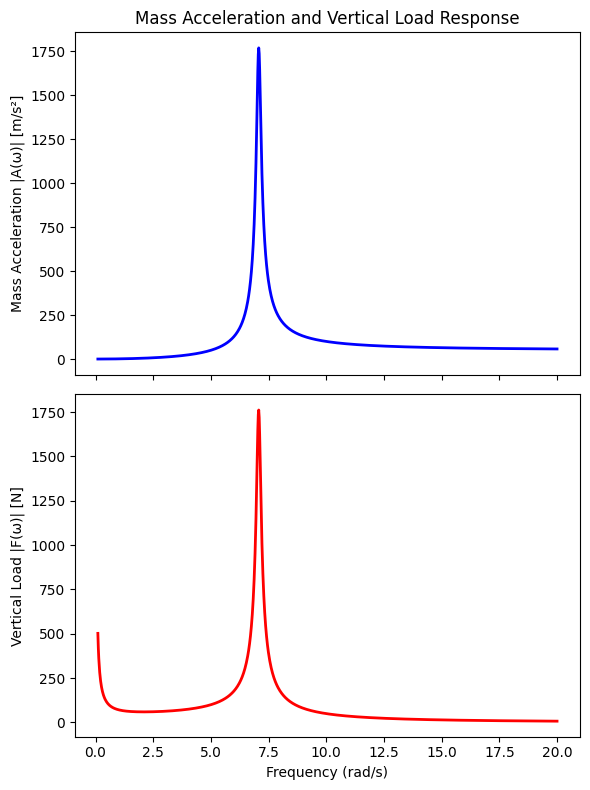

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def dynamic_stiffness(m, c, k, w):
    """ Computes the dynamic stiffness for a single-DOF system: 
        K_d(w) = k - w^2 * m + j * w * c
    """
    return k - (w**2) * m + 1j * w * c

def transfer_function_base_excitation(m, c, k, w):
    """ Computes the displacement response to base velocity excitation:
        H(w) = jω (c + k / (jω)) / K_d(w)
    """
    K_d = dynamic_stiffness(m, c, k, w)
    numerator = 1j * w * (c + k / (1j * w))  # jω (c + k/jω)
    return numerator / K_d

def mass_acceleration(H_x, w):
    """ Computes acceleration response: A(w) = -ω² * X(w) """
    return -w**2 * H_x

def vertical_load(H_x, w, c, k):
    """ Computes vertical force response: 
        F(w) = (k + jωc) * (X(w) - V_base / jω)
    """
    return (k + 1j * w * c) * (H_x - (1 / (1j * w)))

# System parameters
m = 1.0      # Mass [kg]
c = 0.2      # Damping coefficient [N s/m]
k = 50.0     # Stiffness [N/m]

# Frequency range
w_min = 0.1   # Avoid division by zero
w_max = 20.0
num_points = 1000
w_vals = np.linspace(w_min, w_max, num_points)

# Compute frequency response function
H_x_vals = np.array([transfer_function_base_excitation(m, c, k, w) for w in w_vals])
H_a_vals = mass_acceleration(H_x_vals, w_vals)  # Acceleration response
H_f_vals = vertical_load(H_x_vals, w_vals, c, k)  # Vertical force response

# Extract magnitude and phase
A_mag = np.abs(H_a_vals)  # Acceleration magnitude
A_phase = np.angle(H_a_vals)  # Acceleration phase

F_mag = np.abs(H_f_vals)  # Force magnitude
F_phase = np.angle(H_f_vals)  # Force phase

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# Acceleration plot
ax1.plot(w_vals, A_mag, 'b', lw=2)
ax1.set_ylabel('Mass Acceleration |A(ω)| [m/s²]')
ax1.set_title('Mass Acceleration and Vertical Load Response')

# Force plot
ax2.plot(w_vals, F_mag, 'r', lw=2)
ax2.set_xlabel('Frequency (rad/s)')
ax2.set_ylabel('Vertical Load |F(ω)| [N]')

plt.tight_layout()
plt.show()

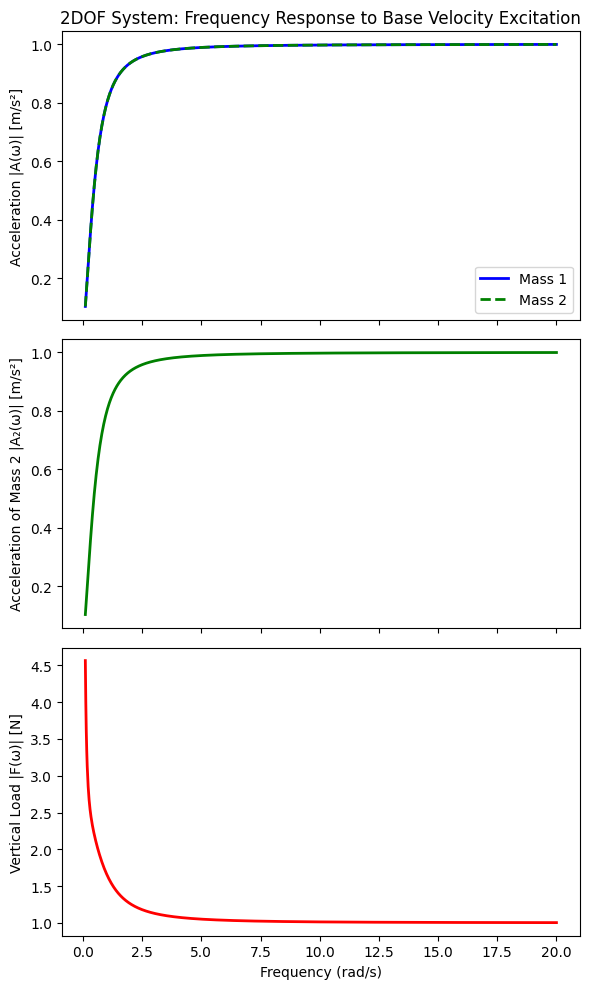

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def dynamic_stiffness(m, c, k, w):
    """Computes the dynamic stiffness: K_d(w) = k - w^2 * m + j * w * c"""
    return k - (w**2) * m + 1j * w * c

def compute_2DOF_response(m1, c1, k1, m2, c2, k2, w):
    """Solves for X1 and X2 given a base velocity excitation"""
    
    # Compute dynamic stiffness terms
    Kd1 = dynamic_stiffness(m1, c1, k1, w)
    Kd2 = dynamic_stiffness(m2, c2, k2, w)
    
    # Construct system matrix
    M = np.array([[Kd1 + Kd2, -Kd2],
                  [-Kd2, Kd2]])

    # Right-hand side vector
    RHS = np.array([-(1j * w * c1 + k1) * (1 / (1j * w)), 0])

    # Solve for displacements X1 and X2
    X1, X2 = np.linalg.solve(M, RHS)

    return X1, X2

def vertical_load(X1, w, c1, k1):
    """Computes vertical force response at lower suspension"""
    return (k1 + 1j * w * c1) * (X1 - (1 / (1j * w)))

# System parameters
m1 = 1.0   # Lower mass [kg]
c1 = 1.0   # Lower damping [N s/m]
k1 = 0.20  # Lower stiffness [N/m]

m2 = 1.0   # Upper mass [kg]
c2 = 1.0   # Upper damping [N s/m]
k2 = 0.40  # Upper stiffness [N/m]

# Frequency range
w_min = 0.1   # Avoid division by zero
w_max = 20.0
num_points = 1000
w_vals = np.linspace(w_min, w_max, num_points)

# Compute response for each frequency
X1_vals = np.zeros_like(w_vals, dtype=complex)
X2_vals = np.zeros_like(w_vals, dtype=complex)

for i, w in enumerate(w_vals):
    X1_vals[i], X2_vals[i] = compute_2DOF_response(m1, c1, k1, m2, c2, k2, w)

# Compute acceleration responses
A1_vals = -w_vals**2 * X1_vals  # Lower mass acceleration
A2_vals = -w_vals**2 * X2_vals  # Upper mass acceleration

# Compute vertical load response
F_lower_vals = vertical_load(X1_vals, w_vals, c1, k1)

# Extract magnitudes and phases
A1_mag = np.abs(A1_vals)
A1_phase = np.angle(A1_vals)

A2_mag = np.abs(A2_vals)
A2_phase = np.angle(A2_vals)

F_mag = np.abs(F_lower_vals)
F_phase = np.angle(F_lower_vals)

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

# Acceleration of mass 1
ax1.plot(w_vals, A1_mag, 'b', lw=2, label="Mass 1")
ax1.plot(w_vals, A2_mag, 'g', lw=2, linestyle="dashed", label="Mass 2")
ax1.set_ylabel('Acceleration |A(ω)| [m/s²]')
ax1.set_title('2DOF System: Frequency Response to Base Velocity Excitation')
ax1.legend()

# Acceleration of mass 2
ax2.plot(w_vals, A2_mag, 'g', lw=2)
ax2.set_ylabel('Acceleration of Mass 2 |A₂(ω)| [m/s²]')

# Vertical load force
ax3.plot(w_vals, F_mag, 'r', lw=2)
ax3.set_xlabel('Frequency (rad/s)')
ax3.set_ylabel('Vertical Load |F(ω)| [N]')

plt.tight_layout()
plt.show()

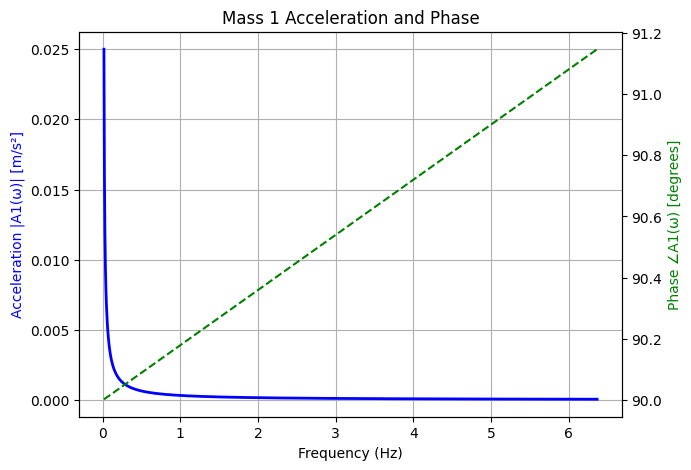

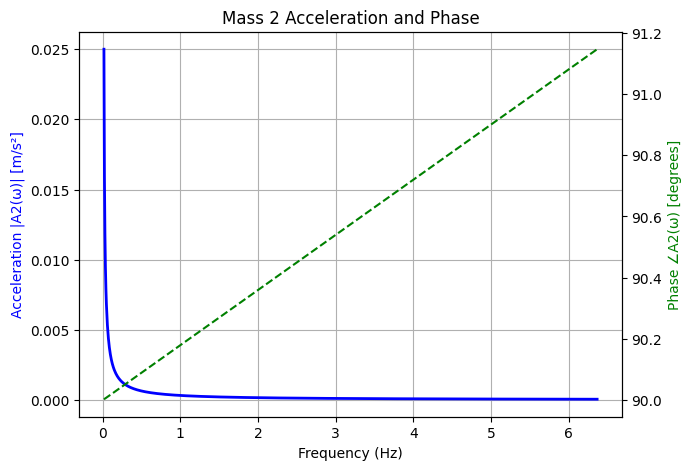

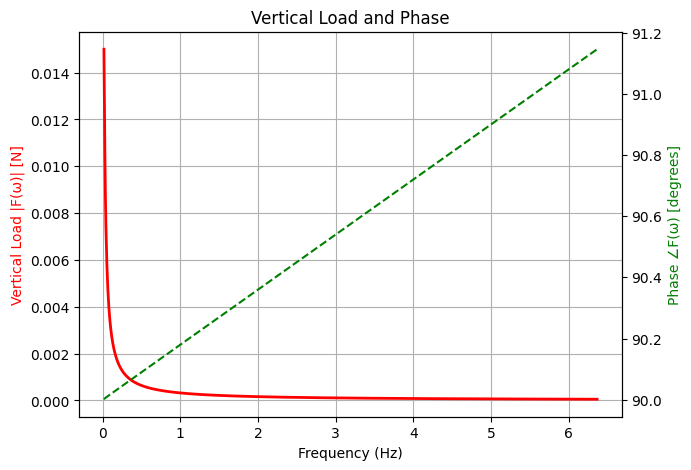

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def dynamic_stiffness(m, c, k, w):
    """Computes the dynamic stiffness: K_d(w) = k - w^2 * m + j * w * c"""
    return k - (w**2) * m + 1j * w * c

def compute_2DOF_response(m1, c1, k1, m2, c2, k2, w):
    """Solves for X1 and X2 given a base velocity excitation"""
    
    # Compute dynamic stiffness terms
    Kd1 = dynamic_stiffness(m1, c1, k1, w)
    Kd2 = dynamic_stiffness(m2, c2, k2, w)
    
    # Construct system matrix
    M = np.array([[Kd1 + Kd2, -Kd2],
                  [-Kd2, Kd2]])

    # Right-hand side vector
    RHS = np.array([-(1j * w * c1 + k1) * (1 / (1j * w)), 0])

    # Solve for displacements X1 and X2
    X1, X2 = np.linalg.solve(M, RHS)

    return X1, X2

def vertical_load(X1, w, c1, k1):
    """Computes vertical force response at lower suspension"""
    return (k1 + 1j * w * c1) * (X1 - (1 / (1j * w)))

# System parameters
m1 = 1.0   # Lower mass [kg]
c1 = 0.000001   # Lower damping [N s/m]
k1 = 0.002  # Lower stiffness [N/m]

m2 = 1.0   # Upper mass [kg]
c2 = 0.000001   # Upper damping [N s/m]
k2 = 0.004  # Upper stiffness [N/m]

# Frequency range (Convert from rad/s to Hz)
w_min = 0.1   # Avoid division by zero
w_max = 40.0
num_points = 1000
w_vals = np.linspace(w_min, w_max, num_points)
f_vals = w_vals / (2 * np.pi)  # Convert to Hz

# Compute response for each frequency
X1_vals = np.zeros_like(w_vals, dtype=complex)
X2_vals = np.zeros_like(w_vals, dtype=complex)

for i, w in enumerate(w_vals):
    X1_vals[i], X2_vals[i] = compute_2DOF_response(m1, c1, k1, m2, c2, k2, w)

# Compute acceleration responses
A1_vals = -w_vals**2 * X1_vals  # Lower mass acceleration
A2_vals = -w_vals**2 * X2_vals  # Upper mass acceleration

# Compute vertical load response
F_lower_vals = vertical_load(X1_vals, w_vals, c1, k1)

# Extract magnitudes and phases
A1_mag = np.abs(A1_vals)
A1_phase = np.angle(A1_vals, deg=True)  # Convert to degrees

A2_mag = np.abs(A2_vals)
A2_phase = np.angle(A2_vals, deg=True)

F_mag = np.abs(F_lower_vals)
F_phase = np.angle(F_lower_vals, deg=True)

# Plot: Mass 1 Acceleration with Phase on Secondary Axis
fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()

ax1.plot(f_vals, A1_mag, 'b', lw=2, label="Acceleration |A1(ω)|")
ax2.plot(f_vals, A1_phase, 'g', lw=1.5, linestyle="dashed", label="Phase ∠A1(ω)")

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Acceleration |A1(ω)| [m/s²]', color='b')
ax2.set_ylabel('Phase ∠A1(ω) [degrees]', color='g')

ax1.set_title('Mass 1 Acceleration and Phase')
ax1.grid()
plt.show()

# Plot: Mass 2 Acceleration with Phase on Secondary Axis
fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()

ax1.plot(f_vals, A2_mag, 'b', lw=2, label="Acceleration |A2(ω)|")
ax2.plot(f_vals, A2_phase, 'g', lw=1.5, linestyle="dashed", label="Phase ∠A2(ω)")

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Acceleration |A2(ω)| [m/s²]', color='b')
ax2.set_ylabel('Phase ∠A2(ω) [degrees]', color='g')

ax1.set_title('Mass 2 Acceleration and Phase')
ax1.grid()
plt.show()

# Plot: Vertical Load with Phase on Secondary Axis
fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()

ax1.plot(f_vals, F_mag, 'r', lw=2, label="Vertical Load |F(ω)|")
ax2.plot(f_vals, F_phase, 'g', lw=1.5, linestyle="dashed", label="Phase ∠F(ω)")

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Vertical Load |F(ω)| [N]', color='r')
ax2.set_ylabel('Phase ∠F(ω) [degrees]', color='g')

ax1.set_title('Vertical Load and Phase')
ax1.grid()
plt.show()

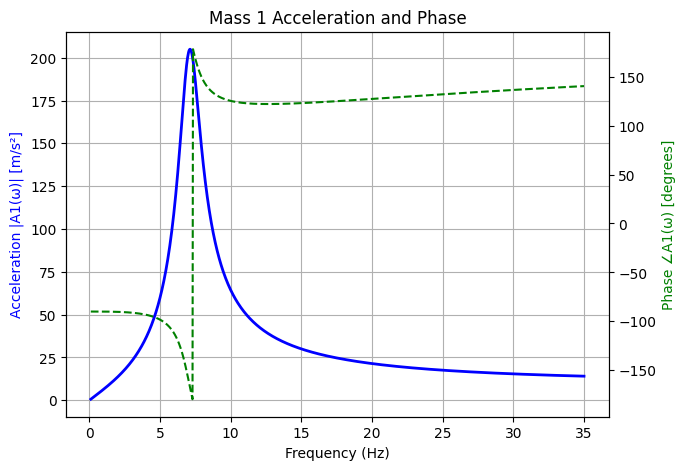

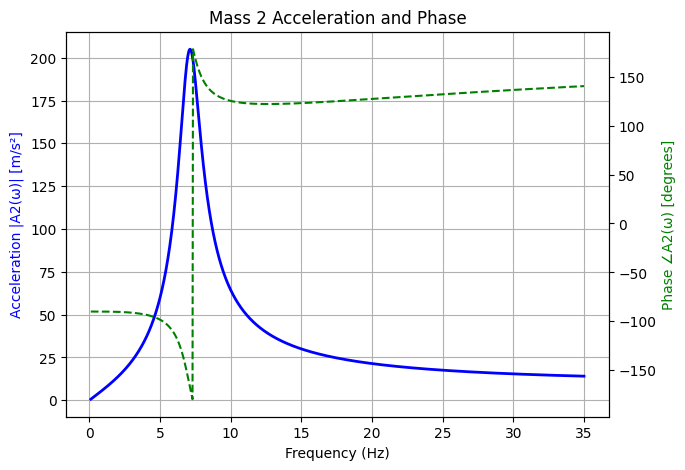

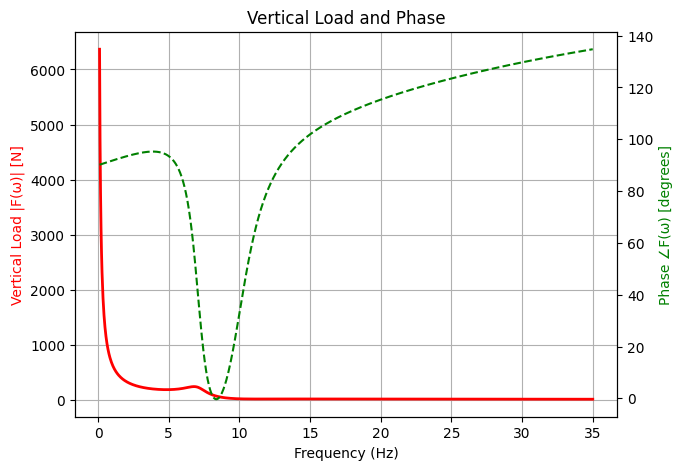

In [3]:
# Updated System Parameters (from image)
m1 = 1.0   # Lower mass [kg]
c1 = 10.0  # Lower damping [Ns/m] (converted from 0.01 Ns/mm)
k1 = 2000.0  # Lower stiffness [N/m] (converted from 2 N/mm)

m2 = 1.0   # Upper mass [kg]
c2 = 1.0   # Upper damping [Ns/m] (converted from 0.001 Ns/mm)
k2 = 4000.0  # Upper stiffness [N/m] (converted from 4 N/mm)

# Updated Frequency Range (0 to 35 Hz)
f_min = 0.1   # Avoid division by zero
f_max = 35.0
num_points = 1000
f_vals = np.linspace(f_min, f_max, num_points)
w_vals = 2 * np.pi * f_vals  # Convert Hz to rad/s

# Compute response for each frequency
X1_vals = np.zeros_like(w_vals, dtype=complex)
X2_vals = np.zeros_like(w_vals, dtype=complex)

for i, w in enumerate(w_vals):
    X1_vals[i], X2_vals[i] = compute_2DOF_response(m1, c1, k1, m2, c2, k2, w)

# Compute acceleration responses
A1_vals = -w_vals**2 * X1_vals  # Lower mass acceleration
A2_vals = -w_vals**2 * X2_vals  # Upper mass acceleration

# Compute vertical load response
F_lower_vals = vertical_load(X1_vals, w_vals, c1, k1)

# Extract magnitudes and phases
A1_mag = np.abs(A1_vals)
A1_phase = np.angle(A1_vals, deg=True)  # Convert to degrees

A2_mag = np.abs(A2_vals)
A2_phase = np.angle(A2_vals, deg=True)

F_mag = np.abs(F_lower_vals)
F_phase = np.angle(F_lower_vals, deg=True)

# Plot: Mass 1 Acceleration with Phase on Secondary Axis
fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()

ax1.plot(f_vals, A1_mag, 'b', lw=2, label="Acceleration |A1(ω)|")
ax2.plot(f_vals, A1_phase, 'g', lw=1.5, linestyle="dashed", label="Phase ∠A1(ω)")

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Acceleration |A1(ω)| [m/s²]', color='b')
ax2.set_ylabel('Phase ∠A1(ω) [degrees]', color='g')

ax1.set_title('Mass 1 Acceleration and Phase')
ax1.grid()
plt.show()

# Plot: Mass 2 Acceleration with Phase on Secondary Axis
fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()

ax1.plot(f_vals, A2_mag, 'b', lw=2, label="Acceleration |A2(ω)|")
ax2.plot(f_vals, A2_phase, 'g', lw=1.5, linestyle="dashed", label="Phase ∠A2(ω)")

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Acceleration |A2(ω)| [m/s²]', color='b')
ax2.set_ylabel('Phase ∠A2(ω) [degrees]', color='g')

ax1.set_title('Mass 2 Acceleration and Phase')
ax1.grid()
plt.show()

# Plot: Vertical Load with Phase on Secondary Axis
fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()

ax1.plot(f_vals, F_mag, 'r', lw=2, label="Vertical Load |F(ω)|")
ax2.plot(f_vals, F_phase, 'g', lw=1.5, linestyle="dashed", label="Phase ∠F(ω)")

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Vertical Load |F(ω)| [N]', color='r')
ax2.set_ylabel('Phase ∠F(ω) [degrees]', color='g')

ax1.set_title('Vertical Load and Phase')
ax1.grid()
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def dynamic_stiffness(m, c, k, w):
    """Computes the dynamic stiffness: K_d(w) = k - w^2 * m + j * w * c"""
    return k - (w**2) * m + 1j * w * c

def compute_2DOF_response(m1, c1, k1, m2, c2, k2, w):
    """Solves for X1 and X2 given a base velocity excitation"""
    
    # Compute dynamic stiffness terms
    Kd1 = dynamic_stiffness(m1, c1, k1, w)
    Kd2 = dynamic_stiffness(m2, c2, k2, w)
    
    # Define base velocity excitation (1 m/s)
    V_base = 1.0  # Unit velocity excitation
    X_base = V_base / (1j * w)  # Convert velocity to displacement in frequency domain

    # Construct system matrix
    M = np.array([[Kd1 + Kd2, -Kd2],
                  [-Kd2, Kd2]])

    # Right-hand side force vector due to base velocity excitation
    F_input = -(j * w * c1 + k1) * X_base
    RHS = np.array([F_input, 0])

    # Solve for displacements X1 and X2
    X1, X2 = np.linalg.solve(M, RHS)

    return X1, X2

def vertical_load(X1, w, c1, k1):
    """Computes vertical force response at lower suspension"""
    return (k1 + 1j * w * c1) * (X1 - (1 / (1j * w)))

# Updated System Parameters (from image)
m1 = 1.0   # Lower mass [kg]
c1 = 10.0  # Lower damping [Ns/m] (converted from 0.01 Ns/mm)
k1 = 2000.0  # Lower stiffness [N/m] (converted from 2 N/mm)

m2 = 1.0   # Upper mass [kg]
c2 = 1.0   # Upper damping [Ns/m] (converted from 0.001 Ns/mm)
k2 = 4000.0  # Upper stiffness [N/m] (converted from 4 N/mm)

# Updated Frequency Range (0 to 35 Hz)
f_min = 0.1   # Avoid division by zero
f_max = 35.0
num_points = 1000
f_vals = np.linspace(f_min, f_max, num_points)
w_vals = 2 * np.pi * f_vals  # Convert Hz to rad/s

# Compute response for each frequency
X1_vals = np.zeros_like(w_vals, dtype=complex)
X2_vals = np.zeros_like(w_vals, dtype=complex)

for i, w in enumerate(w_vals):
    X1_vals[i], X2_vals[i] = compute_2DOF_response(m1, c1, k1, m2, c2, k2, w)

# Compute acceleration responses
A1_vals = -w_vals**2 * X1_vals  # Lower mass acceleration
A2_vals = -w_vals**2 * X2_vals  # Upper mass acceleration

# Compute vertical load response
F_lower_vals = vertical_load(X1_vals, w_vals, c1, k1)

# Extract magnitudes and phases
A1_mag = np.abs(A1_vals)
A1_phase = np.angle(A1_vals, deg=True)  # Convert to degrees

A2_mag = np.abs(A2_vals)
A2_phase = np.angle(A2_vals, deg=True)

F_mag = np.abs(F_lower_vals)
F_phase = np.angle(F_lower_vals, deg=True)

# Plot: Mass 1 Acceleration with Phase on Secondary Axis
fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()

ax1.plot(f_vals, A1_mag, 'b', lw=2, label="Acceleration |A1(ω)|")
ax2.plot(f_vals, A1_phase, 'g', lw=1.5, linestyle="dashed", label="Phase ∠A1(ω)")

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Acceleration |A1(ω)| [m/s²]', color='b')
ax2.set_ylabel('Phase ∠A1(ω) [degrees]', color='g')

ax1.set_title('Mass 1 Acceleration and Phase')
ax1.grid()
plt.show()

# Plot: Mass 2 Acceleration with Phase on Secondary Axis
fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()

ax1.plot(f_vals, A2_mag, 'b', lw=2, label="Acceleration |A2(ω)|")
ax2.plot(f_vals, A2_phase, 'g', lw=1.5, linestyle="dashed", label="Phase ∠A2(ω)")

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Acceleration |A2(ω)| [m/s²]', color='b')
ax2.set_ylabel('Phase ∠A2(ω) [degrees]', color='g')

ax1.set_title('Mass 2 Acceleration and Phase')
ax1.grid()
plt.show()

# Plot: Vertical Load with Phase on Secondary Axis
fig, ax1 = plt.subplots(figsize=(7, 5))
ax2 = ax1.twinx()

ax1.plot(f_vals, F_mag, 'r', lw=2, label="Vertical Load |F(ω)|")
ax2.plot(f_vals, F_phase, 'g', lw=1.5, linestyle="dashed", label="Phase ∠F(ω)")

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Vertical Load |F(ω)| [N]', color='r')
ax2.set_ylabel('Phase ∠F(ω) [degrees]', color='g')

ax1.set_title('Vertical Load and Phase')
ax1.grid()
plt.show()

NameError: name 'j' is not defined